<a href="https://colab.research.google.com/github/elenakelly/Image-Segmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-qbgugvvy
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-qbgugvvy
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


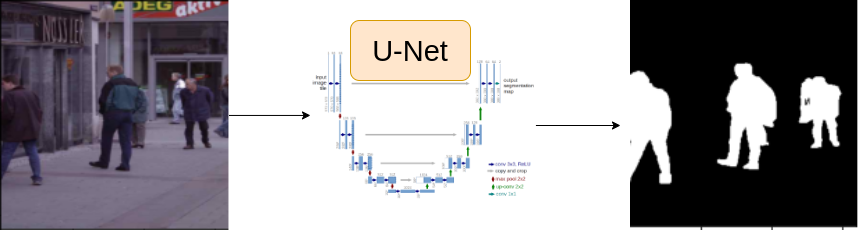

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

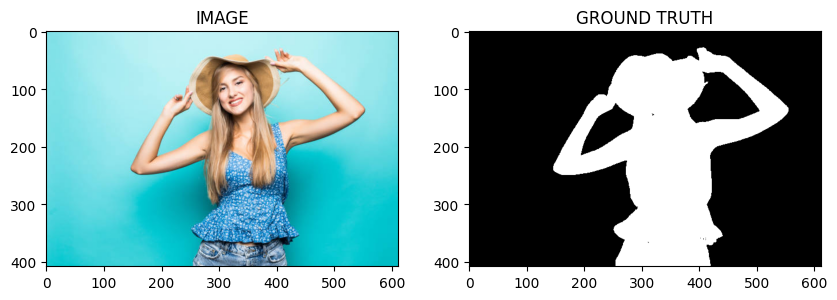

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
# split data
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply-True),
                    A.HorizontalFlip(p=0.5),  # chance of flip
                    A.VerticalFlip(p=0.5)
  ],is_check_shapes= 0)

def get_valid_augs():
  return A.Compose([
                    A.Resize(IMAGE_SIZE, IMAGE_SIZE, always_apply-True),
  ],is_check_shapes= 0)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = self.df.iloc[index]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape = (h, w)
    mask = np.expand_dims(mask, axis=-1)  # convert to shape = (h, w, c) w/ c=1

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # shift (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # c:axis=2
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)  # to 0 and 1 (we have 2 classes)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


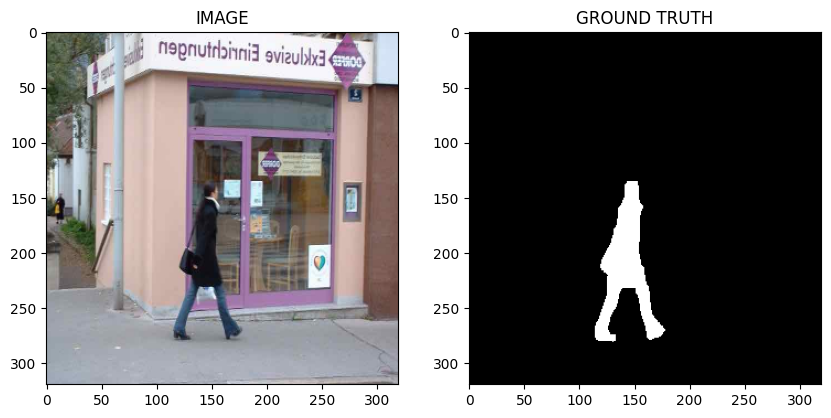

In [ ]:
idx = 33

image, mask= trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentationModel, self).__init__() # usually do to create model in Pytorch

      self.arc = smp.Unet(
          encoder_name=ENCODER,
          encoder_weights=WEIGHTS,
          in_channels=3,
          classes=1,
          activation=None # output logits will be raw
      )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None: # must use != else does not run in training: "Boolean value of Tensor with more than one value is ambiguous"
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [ ]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


SAVED-MODEL
Epoch: 1 Train_loss: 0.675051212310791 Valid_loss: 0.7066217958927155


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


SAVED-MODEL
Epoch: 2 Train_loss: 0.42383349537849424 Valid_loss: 0.41862064599990845


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED-MODEL
Epoch: 3 Train_loss: 0.30995863179365796 Valid_loss: 0.2961372509598732


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 4 Train_loss: 0.24984267155329387 Valid_loss: 0.3521402031183243


100%|██████████| 4/4 [00:00<00:00,  4.21it/s]


SAVED-MODEL
Epoch: 5 Train_loss: 0.24265281856060028 Valid_loss: 0.27350811660289764


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED-MODEL
Epoch: 6 Train_loss: 0.19605664908885956 Valid_loss: 0.23815784975886345


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED-MODEL
Epoch: 7 Train_loss: 0.21298319101333618 Valid_loss: 0.20828122273087502


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Epoch: 8 Train_loss: 0.19946240037679672 Valid_loss: 0.23352829739451408


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 9 Train_loss: 0.2065145601828893 Valid_loss: 0.277744822204113


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED-MODEL
Epoch: 10 Train_loss: 0.20935018757979076 Valid_loss: 0.18900714069604874


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 11 Train_loss: 0.2424474686384201 Valid_loss: 0.23364993184804916


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 12 Train_loss: 0.17209508419036865 Valid_loss: 0.2557491958141327


100%|██████████| 4/4 [00:01<00:00,  3.91it/s]


Epoch: 13 Train_loss: 0.1708474725484848 Valid_loss: 0.2375878095626831


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


Epoch: 14 Train_loss: 0.15029311329126357 Valid_loss: 0.2036290280520916


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch: 15 Train_loss: 0.12672649522622426 Valid_loss: 0.200912369415164


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


SAVED-MODEL
Epoch: 16 Train_loss: 0.12864854087432226 Valid_loss: 0.1850660853087902


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 17 Train_loss: 0.1269101401170095 Valid_loss: 0.21744616888463497


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 18 Train_loss: 0.1372066671649615 Valid_loss: 0.22373216599225998


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch: 19 Train_loss: 0.11524425894021988 Valid_loss: 0.21187120489776134


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 20 Train_loss: 0.09342688272396724 Valid_loss: 0.24392374604940414


100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch: 21 Train_loss: 0.10255876431862514 Valid_loss: 0.22434815391898155


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch: 22 Train_loss: 0.11754614710807801 Valid_loss: 0.2641914263367653


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 23 Train_loss: 0.11866397509972254 Valid_loss: 0.21611886471509933


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


Epoch: 24 Train_loss: 0.1257838855187098 Valid_loss: 0.2412080056965351


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

Epoch: 25 Train_loss: 0.12306501269340515 Valid_loss: 0.18574362620711327


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask =validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c,h,w) -> (1,c,h,w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5) *1.0

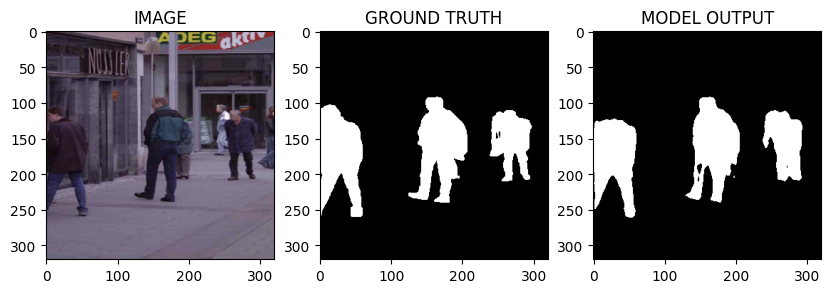

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))